# Beer type preferences

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm import tqdm
import pickle
import matplotlib as m
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import statsmodels.api as sm
import statsmodels.formula.api as smf

## Functions

In [5]:
def get_LR(data, columns):
    data_to_process = data.copy() # copy original dataset
    
    # create formula
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    for el in columns[1:-1]:
        formula += ' + ' + el
    
    # standardization and creation of the formula
    columns.append('rating')  # add rating for the linear regression and standardization
    data_to_process = data_to_process[columns].dropna().sample(frac=1)  # only keeps columns of interest and shuffle the samples
    data_to_process['rating'] = (data_to_process['rating'] - data_to_process['rating'].mean()) / data_to_process['rating'].std()
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

In [6]:
def styles_rephrase(lst_styles):
    # replace some characters
    old_values = [' ', '-', '/', '(', ')', '&', ',', '____', '___', '__', 'style_']
    for val in old_values:
        lst_styles = lst_styles.str.replace(val,'_')
    
    # remove '_' if in first or last position of style name
    lst_styles = [x.rstrip('_') for x in lst_styles]
    lst_styles = [x.lstrip('_') for x in lst_styles]
    
    return lst_styles

In [147]:
def get_category(df):
    # rephrase styles
    old_values = [' ', '-', '/', '\(', '\)', '\&', ',']
    df.replace(
        to_replace={'style':old_values},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'____'},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'___'},
        value='_',
        regex=True,
        inplace=True,
    )
    df.replace(
        to_replace={'style':'__'},
        value='_',
        regex=True,
        inplace=True,
    )
    df['style'] = df['style'].str.strip('_')

    # load csv
    df_styles_to_cat = pd.read_csv('../data/preprocessed/styles_to_categories.csv', sep=';')

    # add category for each review
    df['category'] = "nothing"
    for cat in df_styles_to_cat.columns:
        for style in df_styles_to_cat[cat].dropna():
            df.loc[df['style'] == style, 'category'] = cat

    # remove elements with unknown style
    num_wrong_style = len(df[df.category == 'nothing'])
    if num_wrong_style > 0:
        df = df[df.category != 'nothing']
        print(f"{num_wrong_style} element removed because of unknown style")

    return df

## Loading and selecting data

In [95]:
df_ba = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba.pkl')
df_rb = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb.pkl')

In [98]:
df_ba_style = df_ba[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]
df_rb_style = df_rb[['beer_id', 'beer_name', 'brewery_id', 'brewery_name', 'brewery_location', 'user_location', 'style','rating']]

# creating dataframe for styles/category analysis
df_styles_reviews = pd.concat([df_ba_style, df_rb_style]).reset_index().drop('index', axis=1).dropna()
df_styles_reviews['brewery_location'] = df_styles_reviews['brewery_location'].str.replace("United States, ", "")
df_styles_reviews['user_location'] = df_styles_reviews['user_location'].str.replace("United States, ", "")
df_styles_reviews = get_category(df_styles_reviews)

['BROWNS' 'PALE_ALES' 'WHEATS' 'STOUTS' 'BELGIANS' 'OTHER' 'SOURS'
 'LAGERS' 'PORTERS']


### load categories

## Sorting by countries

In [99]:
user_loc_count = df_styles_reviews.groupby(['user_location'])['user_location'].count().sort_values(ascending=False)

# select countries with more than 100 reviews:
user_loc_count = user_loc_count[user_loc_count > 100]
print(f"Number of countries selected: {len(user_loc_count)}")

Number of countries selected: 119


## Finding favourite category

In [100]:
df_cat_location_dumm = pd.get_dummies(df_styles_reviews, columns=['category'])
best_cat_per_user_location = {}

# remove special characters in columns names
df_cat_location_dumm.columns = df_cat_location_dumm.columns.str.replace('category_', '')

# transform boolean values to int values for linear regression
for col in df_cat_location_dumm.drop(['beer_id', 'beer_name', 'brewery_name', 'brewery_location','user_location', 'brewery_id', 'rating','style'], axis=1).columns:
    df_cat_location_dumm[col] = df_cat_location_dumm[col] * 1

# perform linear regression on each location
columns= list(df_cat_location_dumm.drop(['beer_id', 'beer_name', 'user_location', 'brewery_name', 'brewery_location', 'brewery_id', 'rating', 'style'], axis=1).columns)
for idx, loc in enumerate(list(user_loc_count.keys())):
    df_reviews = df_cat_location_dumm[df_styles_reviews['user_location'] == loc]
    res = get_LR(df_reviews, columns)
    best_cat_per_user_location[loc] = res.params[res.params.keys() != 'Intercept'].sort_values(ascending=False)[0:3]

## Finding most reviewed category

In [101]:
most_reviewed_cat_per_user_location = {}
for idx, loc in enumerate(list(user_loc_count.keys())):
    most_reviewed_cat_per_user_location[loc] = df_styles_reviews[df_styles_reviews['user_location']==loc].groupby(['category'])['category'].count().sort_values(ascending=False)[:3]

## Finding local breweries

In [102]:
frac_reviews_per_brewery = {}

# loop on every location
for idx, loc in tqdm(enumerate(list(user_loc_count.keys())), total=len(list(user_loc_count.keys()))):

    # total number of reviews per brewery
    num_reviews_per_brewery = df_styles_reviews[df_styles_reviews['brewery_location'] == loc] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    # number of local reviews per brewery
    num_reviews_per_brewery_loc = df_styles_reviews[(df_styles_reviews['brewery_location'] == loc) & (df_styles_reviews['user_location'] == loc)] \
    .groupby(['brewery_name'])['brewery_name'] \
    .count() \
    .sort_values(ascending=False)

    num_reviews_per_brewery.keys = num_reviews_per_brewery_loc.keys
    num_reviews_per_brewery = num_reviews_per_brewery.loc[num_reviews_per_brewery_loc.keys()]

    # fraction of local rewviews per brewery (50% and up)
    frac_reviews_per_brewery[loc] = num_reviews_per_brewery_loc.divide(num_reviews_per_brewery).sort_values(ascending=False)
    frac_reviews_per_brewery[loc] = frac_reviews_per_brewery[loc][frac_reviews_per_brewery[loc].values > .5]
    

100%|██████████| 119/119 [00:28<00:00,  4.13it/s]


In [103]:
# removing the locations with no "local" breweries (meaning that there is no brewery with high enough fraction of local reviewers)
init_num_loc = len(frac_reviews_per_brewery)
lst_empty_loc = []
for loc in frac_reviews_per_brewery:
    if len(frac_reviews_per_brewery[loc]) == 0:
        lst_empty_loc.append(loc)
for loc in lst_empty_loc:
    frac_reviews_per_brewery.pop(loc)
lst_locations = list(frac_reviews_per_brewery.keys())

print(f"{str(init_num_loc - len(lst_locations))} locations where removed")

13 locations where removed


## Looking for each country if local breweries is answering to local preferences

### Get the global average representation of each style

#### Find values for "difference" computation

In [104]:
retrain_glob_frac = False
if retrain_glob_frac:
    global_frac_per_cat = {}
    for cat in df_styles_reviews.category.unique():
        print(f"Compute for {cat}...")
        global_frac_per_cat[cat] = 0
        for brewery in list(df_styles_reviews.brewery_name.unique()):
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat[cat] += val[0]
        global_frac_per_cat[cat] /= len(df_styles_reviews.brewery_name.unique())

    # save dictionaries
    with open('./variables/global_frac_per_cat.pickle', 'wb') as handle:
        pickle.dump(global_frac_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/global_frac_per_cat.pickle', 'rb') as handle:
        global_frac_per_cat = pickle.load(handle)

#### Find lists for "zscore" computation

In [106]:
do_retrain_glob_frac_lst = False
if do_retrain_glob_frac_lst:
    global_frac_per_cat_lst = {}
    for cat in df_styles_reviews.category.unique():
        print(f"Compute for {cat}...")
        global_frac_per_cat_lst[cat] = []
        breweries = list(df_styles_reviews.brewery_name.unique())
        for brewery in breweries:
            df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
            val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))
            if val != []:
                global_frac_per_cat_lst[cat].append(val[0])
            else:
                global_frac_per_cat_lst[cat].append(0)
                
    # save dictionaries
    with open('./variables/global_frac_per_cat_lst.pickle', 'wb') as handle:
        pickle.dump(global_frac_per_cat_lst, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/global_frac_per_cat_lst.pickle', 'rb') as handle:
        global_frac_per_cat_lst = pickle.load(handle)

In [107]:
# find mean and std for zscore
global_frac_per_cat_lst_mean = {}
global_frac_per_cat_lst_std = {}
for cat in df_styles_reviews.category.unique():
    global_frac_per_cat_lst_mean[cat] = np.mean(np.asarray(global_frac_per_cat_lst[cat]))
    global_frac_per_cat_lst_std[cat] = np.std(np.asarray(global_frac_per_cat_lst[cat]))

### Compare for each location

In [108]:
do_compare_loc = False
if do_compare_loc == True:
    # loop on every location
    frac_per_loc_per_cat = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()
        cats = best_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat[loc] = {}
        for cat in cats:
            frac_per_loc_per_cat[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)
    
    # save library
    with open('./variables/frac_per_loc_per_cat.pickle', 'wb') as handle:
        pickle.dump(frac_per_loc_per_cat, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/frac_per_loc_per_cat.pickle', 'rb') as handle:
        frac_per_loc_per_cat = pickle.load(handle)

In [109]:
# compute diff and z-score
diff_frac_per_loc_per_cat = {}
zscore_frac_per_loc_per_cat = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat[loc] = {}
    zscore_frac_per_loc_per_cat[loc] = {}
    for cat in frac_per_loc_per_cat[loc]:
        diff_frac_per_loc_per_cat[loc][cat] = frac_per_loc_per_cat[loc][cat] - global_frac_per_cat[cat]
        zscore_frac_per_loc_per_cat[loc][cat] = (frac_per_loc_per_cat[loc][cat] - global_frac_per_cat_lst_mean[cat]) / global_frac_per_cat_lst_std[cat]

## Looking for each country if local breweries is answering to most reviewed

### Compare for each location

In [110]:
do_compare_loc_2 = False
if do_compare_loc_2 == True:
    # loop on every location
    frac_per_loc_per_cat_2 = {}
    for idx, loc in tqdm(enumerate(lst_locations), total=len(lst_locations)):
        breweries = frac_reviews_per_brewery[loc].keys()

        #styles = styles_rephrase(best_type_per_user_location[loc].keys())
        cats = most_reviewed_cat_per_user_location[loc].keys()
        frac_per_loc_per_cat_2[loc] = {}
        for cat in cats:
            frac_per_loc_per_cat_2[loc][cat] = 0
            for brewery in breweries:
                df_brewery = df_styles_reviews[df_styles_reviews['brewery_name'] == brewery][['category','brewery_name']]
                val = list(df_brewery[df_brewery['category'] == cat].groupby('category')['category'].count()/len(df_brewery))

                if val != []:
                    frac_per_loc_per_cat_2[loc][cat] += val[0]
                
            if len(breweries) > 0:
                frac_per_loc_per_cat_2[loc][cat] /= len(breweries)
            else:
                print("No breweries for : " + loc)
                
    # save library
    with open('./variables/frac_per_loc_per_cat_2.pickle', 'wb') as handle:
        pickle.dump(frac_per_loc_per_cat_2, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/frac_per_loc_per_cat_2.pickle', 'rb') as handle:
        frac_per_loc_per_cat_2 = pickle.load(handle)

In [111]:
# compute diff and zscore for most reviewes analysis
diff_frac_per_loc_per_cat_ana2 = {}
zscore_frac_per_loc_per_cat_ana2 = {}
for loc in lst_locations:
    diff_frac_per_loc_per_cat_ana2[loc] = {}
    zscore_frac_per_loc_per_cat_ana2[loc] = {}
    for cat in frac_per_loc_per_cat_2[loc]:
        diff_frac_per_loc_per_cat_ana2[loc][cat] = frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat[cat]
        zscore_frac_per_loc_per_cat_ana2[loc][cat] = (frac_per_loc_per_cat_2[loc][cat] - global_frac_per_cat_lst_mean[cat]) / global_frac_per_cat_lst_std[cat]


## Show results

### Load and merge shapefiles

In [112]:
# Load shapefiles
world = gpd.read_file('../data/shapefiles/world-administrative-boundaries.zip')
states = gpd.read_file('../data/shapefiles/georef-united-states-of-america-state-millesime.zip')

# clean world
world_clean = world[world['name'] != 'United States of America'][['name','geometry']]
world_clean.name = world_clean.name.str.replace("U.K. of Great Britain and Northern Ireland", "England")

# clean states
states.ste_name = states.ste_name.str.replace("['", "")
states.ste_name = states.ste_name.str.replace("']", "")
states_clean = states[['ste_name','geometry']]
states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)

# concatenate
shapefile = pd.concat([world_clean, states_clean], axis=0)

C:\Users\swann\AppData\Local\Temp\ipykernel_18040\3631237360.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_clean.rename({'ste_name':'name'}, inplace=True, axis=1)


### Show main category per location

In [113]:
sf_maincat = shapefile.copy()

# find main category
sf_maincat['main_cat'] = "None"
for loc in lst_locations:
    sf_maincat.loc[sf_maincat['name'] == loc, 'main_cat'] = best_cat_per_user_location[loc].keys()[0]

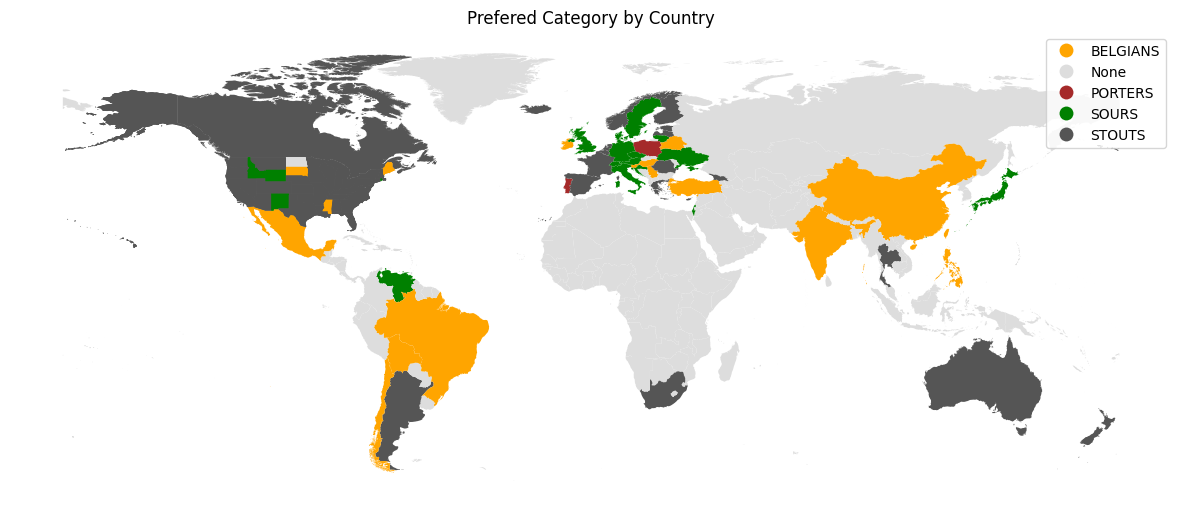

In [114]:
# color map
color_map = ['orange','#dddddd','brown','green','#555555']
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sf_maincat.plot(column='main_cat', cmap=colors.ListedColormap(color_map), ax=ax, legend=True, categorical=True)
plt.title('Prefered Category by Country')
plt.axis('off')
plt.savefig('../results/map_pref_cat.png')
plt.show()

### Show how breweries adapt to local preferences

In [115]:
sf_local_breweries = shapefile.copy()

# add zscore
sf_local_breweries['zscore'] = 0
for loc in lst_locations:
    sf_local_breweries.loc[sf_local_breweries['name'] == loc, 'zscore'] = np.sum(np.asarray(list(zscore_frac_per_loc_per_cat[loc].values())))/3

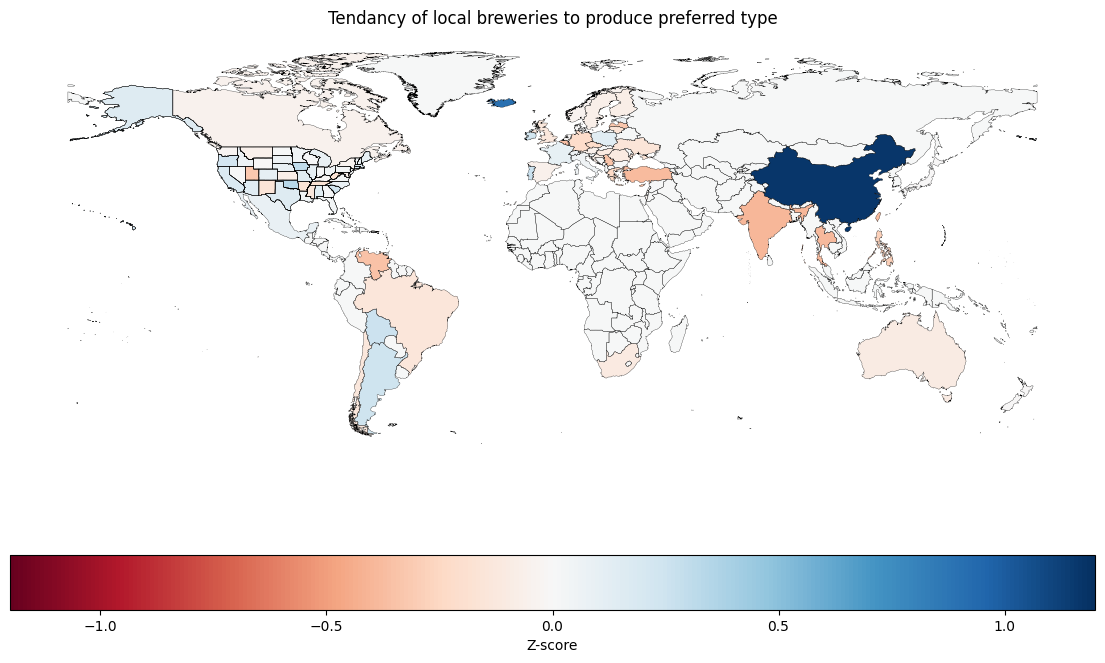

In [133]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(14,8))

sf_maincat.boundary.plot(ax=ax, linewidth=.2, color='black')
im = sf_local_breweries.plot(column='zscore', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Z-score", "orientation": "horizontal"}, vmin=-1.2, vmax=1.2)

plt.title('Tendancy of local breweries to produce preferred type')
plt.axis('off')
plt.savefig('../results/map_local_breweries.png')
plt.show()

### Show how breweries adapt to local most reviewed

In [132]:
sf_local_breweries2 = shapefile.copy()

# add zscore
sf_local_breweries2['zscore'] = 0
for loc in lst_locations:
    sf_local_breweries2.loc[sf_local_breweries2['name'] == loc, 'zscore'] = np.sum(np.asarray(list(zscore_frac_per_loc_per_cat_ana2[loc].values())))/3

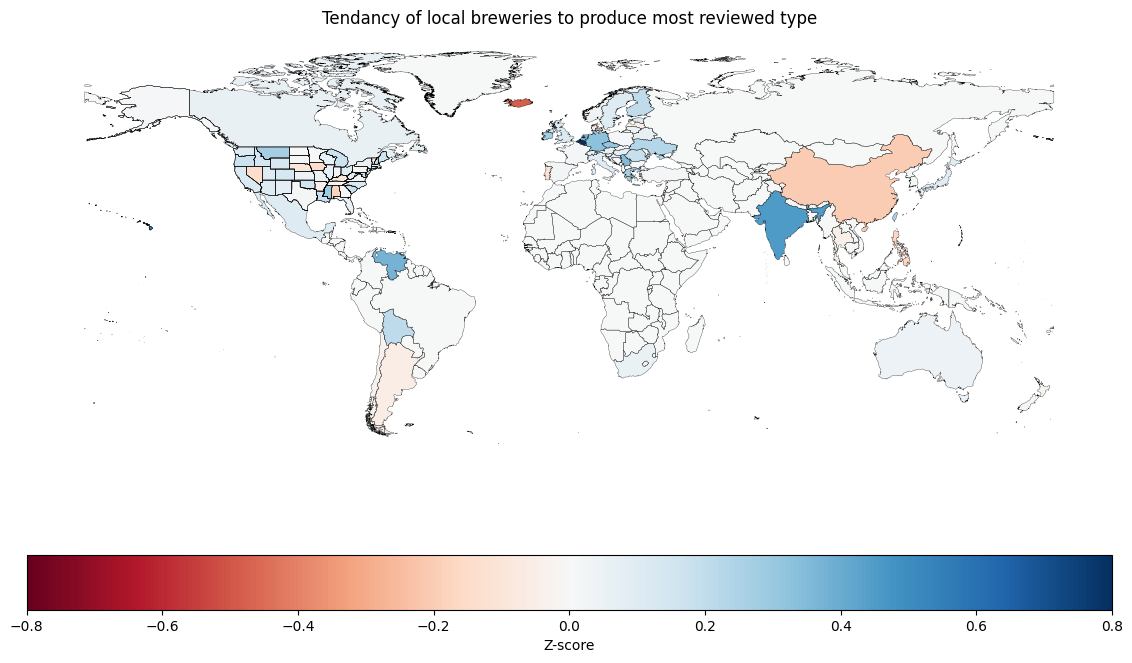

In [134]:
# Plot the main predictor on a world map
fig, ax = plt.subplots(1, 1, figsize=(14,8))

sf_local_breweries2.boundary.plot(ax=ax, linewidth=.2, color='black')
sf_local_breweries2.plot(column='zscore', cmap='RdBu', ax=ax, legend=True, legend_kwds={"label": "Z-score", "orientation": "horizontal"}, vmin=-0.8, vmax=0.8)

plt.title('Tendancy of local breweries to produce most reviewed type')
plt.axis('off')
plt.savefig('../results/map_local_breweries_most_reviewed.png')
plt.show()

# Check for temporal trends between evolution of frac in reviews and frac in breweries propositions

## Find first review date for each beer

In [135]:
first_date_per_beer = {}
do_list_beers = False
if do_list_beers:
    # load full datasets
    df_ba_full = pd.read_pickle('../data/preprocessed/BeerAdvocate/transformed_ratings_ba_full.pkl')
    df_rb_full = pd.read_pickle('../data/preprocessed/RateBeer/transformed_ratings_rb_full.pkl')
    
    # fing beers of beerdavocate (and also look for same beers in ratebeer)
    print('Looking into BeerAdvocate...')
    for idx, beer_id in tqdm(enumerate(list(df_ba_full.beer_id.unique())), total=len(list(df_ba_full.beer_id.unique()))):
        df_ba_beer = df_ba_full[df_ba_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]
        df_rb_beer = df_rb_full[df_rb_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]
        df_beer = pd.concat([df_ba_beer,df_rb_beer], axis=0)

        # add the first date appearing for this beer
        first_date_per_beer[beer_id] = df_beer.sort_values(by='date').iloc[0]

    # find beers of ratebeer that are not in beeradvocate
    print('Looking into RateBeer...')
    list_ba_beers = list(df_ba_full.beer_id.unique())
    list_rb_beers = list(df_rb_full.beer_id.unique())
    list_rb_to_process = list(set(list_rb_beers) - set(list_ba_beers))
    for idx, beer_id in tqdm(enumerate(list_rb_to_process), total=len(list_rb_to_process)):
        df_rb_beer = df_rb_full[df_rb_full['beer_id'] == beer_id][['beer_id', 'beer_name','date','style','brewery_name']]

        # add the first date appearing for this beer
        first_date_per_beer[beer_id] = df_rb_beer.sort_values(by='date').iloc[0]
    
    # save dictionary
    with open('./variables/first_date_per_beer.pickle','wb') as f:
        pickle.dump(first_date_per_beer, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/first_date_per_beer.pickle','rb') as f:
        first_date_per_beer = pickle.load(f)

In [148]:
# select only beers related to the subsample analysis
list_beers_analysis = list(df_styles_reviews.beer_id.unique())
first_date_per_beer = {key:first_date_per_beer[key] for key in list_beers_analysis}
df_first_date_per_beer = pd.DataFrame(first_date_per_beer).transpose().reset_index().drop('index',axis=1)

print(f"{len(df_first_date_per_beer)} beers selected")


208079 beers selected


## Compute time serie of frac per beers

In [150]:
# add category
df_first_date_per_beer = get_category(df_first_date_per_beer)


In [151]:
df_ba_date = df_ba[['date','style']]
df_rb_date = df_rb[['date','style']]
df_date_reviews = pd.concat([df_ba_date, df_rb_date]).reset_index().drop('index', axis=1).dropna()

# add category
df_date_reviews = get_category(df_date_reviews)

In [153]:
"""dic_date_cat_frac = {}
do_find_date_cat_frac = False
if do_find_date_cat_frac:
    lst_date = list(df_date_reviews.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_date_cat_frac[date] = []
        list_reviews_date = list(df_date_reviews[df_date_reviews.date == date])
        for cat in list(df_date_reviews.category.unique()):
            dic_date_cat_frac[date].append(len(df_date_reviews[(df_date_reviews.date == date) & (df_date_reviews.category == cat)]) / len(df_date_reviews[df_date_reviews.date == date]))

    # save dictionary:
    with open('./variables/dic_date_cat_frac2.pickle', 'wb') as f:
        pickle.dump(dic_date_cat_frac, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_date_cat_frac2.pickle', 'rb') as f:
        dic_date_cat_frac = pickle.load(f)"""

"dic_date_cat_frac = {}\ndo_find_date_cat_frac = False\nif do_find_date_cat_frac:\n    lst_date = list(df_date_reviews.date.unique())\n    for date in tqdm(lst_date, total=len(lst_date)):\n        dic_date_cat_frac[date] = []\n        list_reviews_date = list(df_date_reviews[df_date_reviews.date == date])\n        for cat in list(df_date_reviews.category.unique()):\n            dic_date_cat_frac[date].append(len(df_date_reviews[(df_date_reviews.date == date) & (df_date_reviews.category == cat)]) / len(df_date_reviews[df_date_reviews.date == date]))\n\n    # save dictionary:\n    with open('./variables/dic_date_cat_frac2.pickle', 'wb') as f:\n        pickle.dump(dic_date_cat_frac, f, protocol=pickle.HIGHEST_PROTOCOL)\nelse:\n    with open('./variables/dic_date_cat_frac2.pickle', 'rb') as f:\n        dic_date_cat_frac = pickle.load(f)"

In [154]:
dic_date_cat_frac = {}
do_find_date_cat_frac = False
if do_find_date_cat_frac:
    lst_date = list(df_first_date_per_beer.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_date_cat_frac[date] = []
        list_beers_date = list(df_first_date_per_beer[df_first_date_per_beer.date == date].beer_id.unique())
        for cat in list(df_first_date_per_beer.category.unique()):
            dic_date_cat_frac[date].append(len(df_first_date_per_beer[(df_first_date_per_beer.date == date) & (df_first_date_per_beer.category == cat)]) / len(list_beers_date))
    print(dic_date_cat_frac)

    # save dictionary:
    with open('./variables/dic_date_cat_frac.pickle', 'wb') as f:
        pickle.dump(dic_date_cat_frac, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_date_cat_frac.pickle', 'rb') as f:
        dic_date_cat_frac = pickle.load(f)


In [155]:
# from dict to dataframe
df_date_cat_frac = pd.DataFrame(dic_date_cat_frac).transpose().reset_index().sort_values(by='index')
col_names = ["date"]
for x in list(df_date_reviews.category.unique()): col_names.append(x)
df_date_cat_frac.columns = col_names

# transform date to datetime format and average over quarter of year
df_date_cat_frac['date'] = pd.to_datetime(df_date_cat_frac['date'], unit='s')
df_date_cat_frac = df_date_cat_frac.groupby(pd.PeriodIndex(df_date_cat_frac['date'], freq="Q")).mean()


## Compute time serie of frac per breweries

In [156]:
df_cat_date_brewery_ba = df_ba[['beer_id', 'brewery_id', 'brewery_name', 'date', 'style']]
df_cat_date_brewery_rb = df_rb[['beer_id', 'brewery_id', 'brewery_name', 'date', 'style']]
df_cat_date_brewery = pd.concat([df_cat_date_brewery_ba, df_cat_date_brewery_rb]).reset_index().drop('index', axis=1).dropna()

# add category
df_cat_date_brewery = get_category(df_cat_date_brewery)

In [157]:
dic_cat_date_brewery = {}
do_findcatbrewery = False
if do_findcatbrewery:
    lst_date = list(df_cat_date_brewery.date.unique())
    for date in tqdm(lst_date, total=len(lst_date)):
        dic_cat_date_brewery[date] = []
        df_date_entries = df_cat_date_brewery[df_cat_date_brewery.date == date]
        breweries = df_date_entries[df_date_entries.date == date].brewery_name.unique()
        for cat in list(df_cat_date_brewery.category.unique()):
            frac = 0
            for brewery in breweries:
                frac += len(df_date_entries[(df_date_entries.category == cat) & (df_date_entries.brewery_name == brewery)])/len(df_date_entries[df_date_entries.brewery_name == brewery])
            frac /= len(breweries)
            dic_cat_date_brewery[date].append(frac)

    # save dictionary
    with open('./variables/dic_cat_date_brewery.pickle', 'wb') as f:
        pickle.dump(dic_cat_date_brewery, f, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('./variables/dic_cat_date_brewery.pickle', 'rb') as f:
        dic_cat_date_brewery = pickle.load(f)


In [158]:
# from dict to dataframe
df_cat_date_brewery_frac = pd.DataFrame(dic_cat_date_brewery).transpose().reset_index().sort_values(by='index')
col_names = ["date"]
for x in list(df_cat_date_brewery.category.unique()): col_names.append(x)
df_cat_date_brewery_frac.columns = col_names

# transform date to datetime format and average over quarter of year
df_cat_date_brewery_frac['date'] = pd.to_datetime(df_cat_date_brewery_frac['date'], unit='s')
df_cat_date_brewery_frac = df_cat_date_brewery_frac.groupby(pd.PeriodIndex(df_cat_date_brewery_frac['date'], freq="Q")).mean()

## Show results

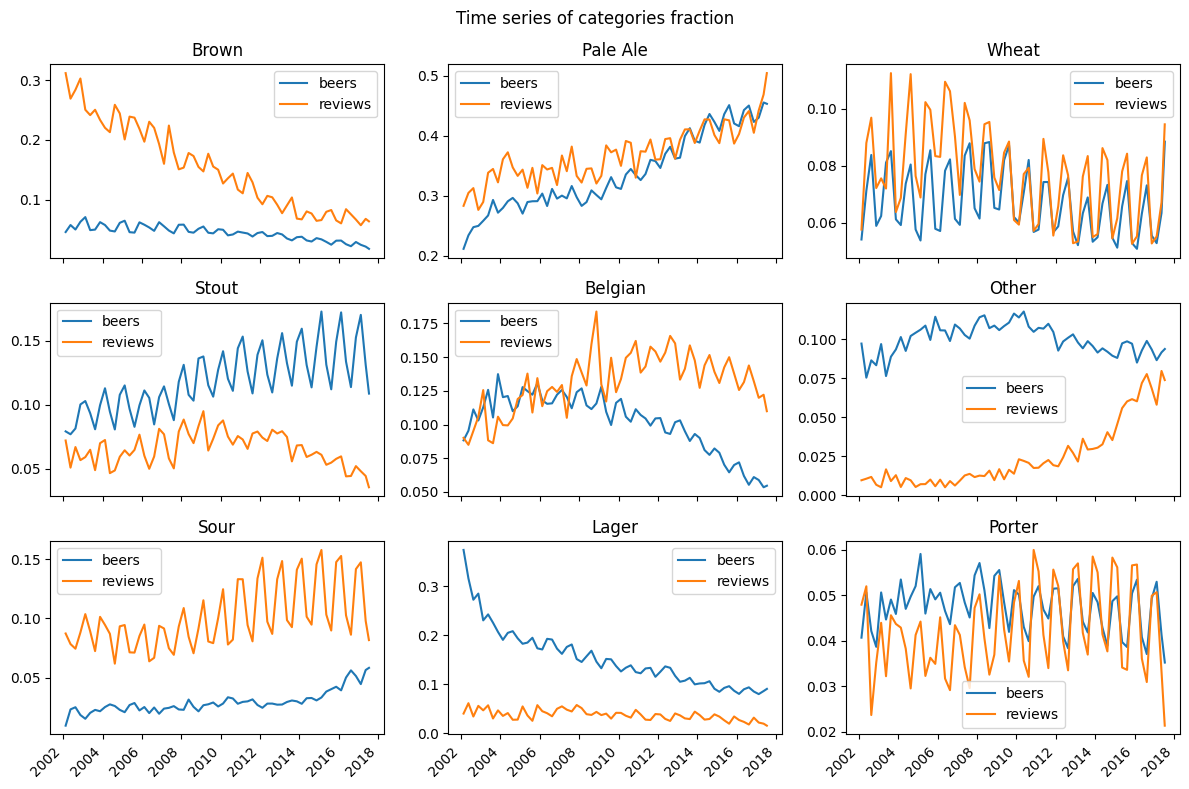

In [159]:
import matplotlib.dates as dates

cat_array = np.asarray(list(df_cat_date_brewery.category.unique())).reshape((3,3))
dict_titles = {
    'BROWNS': 'Brown',
    'PALE_ALES': 'Pale Ale',
    'WHEATS': 'Wheat',
    'STOUTS': 'Stout',
    'BELGIANS': 'Belgian',
    'OTHER': 'Other',
    'SOURS': 'Sour',
    'LAGERS': 'Lager',
    'PORTERS': 'Porter',
}

# select min and max year for timespan of interest
min_year = 2002
max_year = 2017
df_cat_date_brewery_frac = df_cat_date_brewery_frac[(df_cat_date_brewery_frac.date.dt.year >= min_year) & (df_cat_date_brewery_frac.date.dt.year <= max_year)]
df_date_cat_frac = df_date_cat_frac[(df_date_cat_frac.date.dt.year >= min_year) & (df_date_cat_frac.date.dt.year <= max_year)]

# plot results
fig, axs = plt.subplots(3,3, figsize=(12,8), sharex=True)
for i in range(3):
    for j in range(3):
        axs[i,j].plot(df_cat_date_brewery_frac['date'], df_cat_date_brewery_frac[cat_array[i,j]], label='beers')
        axs[i,j].plot(df_date_cat_frac['date'], df_date_cat_frac[cat_array[i,j]], label='reviews')
        axs[i,j].set_title(dict_titles[cat_array[i,j]])
        axs[i,j].legend()
        for label in axs[i,j].get_xticklabels():
            label.set_rotation(45)
            label.set_ha('right')
plt.suptitle('Time series of categories fraction')
plt.tight_layout()
plt.savefig('../results/frac_time_series.png')